In [32]:
#facebook finance as data source
#pip install yfinance
import yfinance as yf

In [33]:
#See the facebook finance ticker for your stock symbol
stock_symbol = 'GAIL.NS'

In [4]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [5]:
type(data)

pandas.core.frame.DataFrame

In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-13,121.316666,126.500000,121.000000,125.150002,99.480835,31544757
2018-08-14,124.883331,128.083328,124.216667,126.599998,100.633430,14297979
2018-08-16,126.566666,133.133331,126.366669,131.266663,104.342918,45437358
2018-08-17,131.333328,132.199997,128.066666,129.233337,102.726646,13509201
2018-08-20,130.033340,130.666672,125.000000,126.349998,100.434700,15107493


In [7]:
len(data)

1234

In [8]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-07,116.000000,116.550003,114.099998,114.250000,114.250000,11480767
2023-08-08,114.300003,116.699997,114.099998,116.400002,116.400002,16636302
2023-08-09,116.949997,118.150002,115.599998,117.900002,117.900002,11556651
2023-08-10,118.599998,119.099998,117.050003,117.599998,117.599998,13140800
2023-08-11,118.050003,118.300003,115.400002,115.699997,115.699997,10818126


In [9]:
opn = data[['Open']]

<Axes: xlabel='Date'>

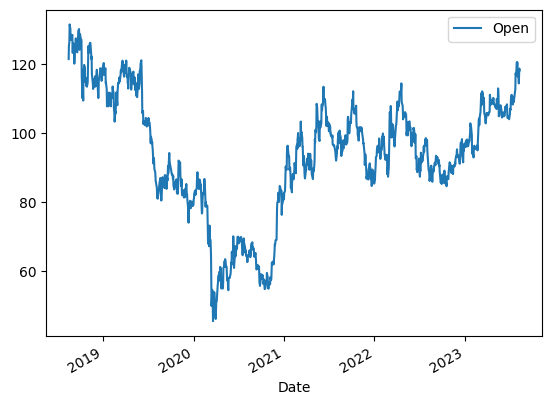

In [10]:
opn.plot()

In [11]:
import matplotlib.pyplot as plt

In [12]:
ds = opn.values

In [13]:
ds

array([[121.31666565],
       [124.8833313 ],
       [126.56666565],
       ...,
       [116.94999695],
       [118.59999847],
       [118.05000305]])

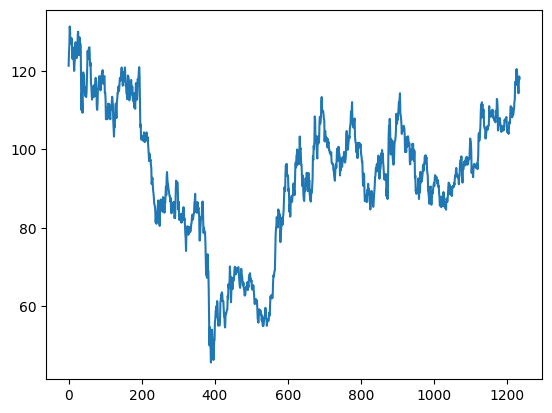

In [14]:
plt.plot(ds)

In [15]:
import numpy as np

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [18]:
len(ds_scaled), len(ds)

(1234, 1234)

In [19]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [20]:
train_size,test_size

(863, 371)

In [21]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [22]:
len(ds_train),len(ds_test)

(863, 371)

In [23]:
#creating dataset in time series for LSTM model
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [24]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [25]:
X_train.shape,y_train.shape

((762, 100), (762,))

In [26]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [27]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [28]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [29]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [30]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 10s 359ms/step - loss: 0.0870 - val_loss: 0.0059
Epoch 2/100
12/12 [==============================] - 4s 292ms/step - loss: 0.0132 - val_loss: 0.0031
Epoch 3/100
12/12 [==============================] - 3s 213ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 4/100
12/12 [==============================] - 3s 215ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 5/100
12/12 [==============================] - 3s 217ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 6/100
12/12 [==============================] - 4s 320ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 7/100
12/12 [==============================] - 4s 324ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 8/100
12/12 [==============================] - 3s 219ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 9/100
12/12 [==============================] - 3s 212ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 10/100
12/12 [==============================] - 3s 228ms/step - loss: 0.0035 - val_l

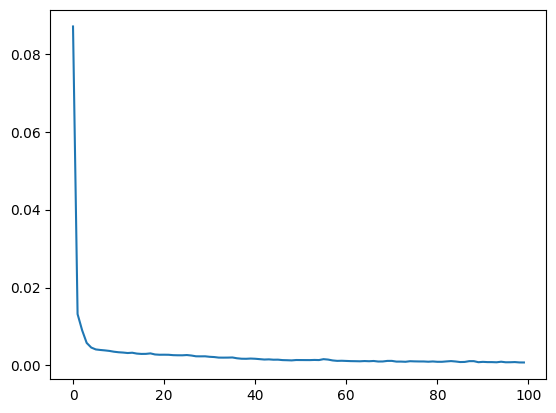

In [31]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [34]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 44ms/step


In [35]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

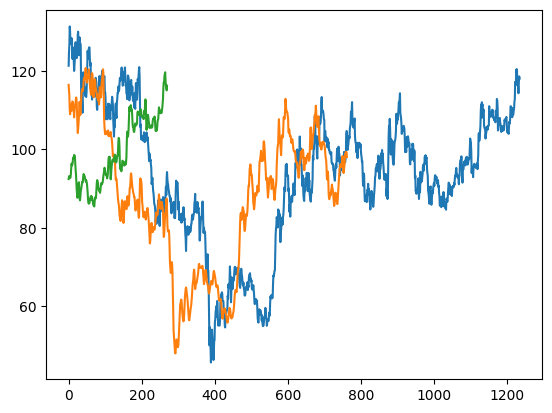

In [36]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [37]:
type(train_predict)

numpy.ndarray

In [38]:
test = np.vstack((train_predict,test_predict))

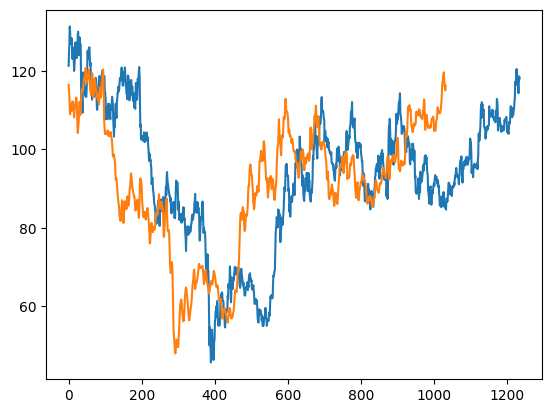

In [39]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [40]:
len(ds_test)

371

In [41]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [42]:
fut_inp = fut_inp.reshape(1,-1)

In [43]:
tmp_inp = list(fut_inp)

In [44]:
fut_inp.shape

(1, 101)

In [45]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [46]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[[0.8543206453323364], [0.856867253780365], [0.8586278557777405], [0.8599045276641846], [0.8608402609825134], [0.8616284728050232], [0.8624224662780762], [0.8633121848106384], [0.8643332719802856], [0.8654835820198059], [0.8667401671409607], [0.868068277835846], [0.8694328665733337], [0.8708025813102722], [0.87215256690979], [0.8734663724899292], [0.8747342228889465], [0.8759525418281555], [0.8771220445632935], [0.8782459497451782], [0.879330039024353], [0.880378782749176], [0.8813979029655457], [0.8823916912078857], [0.8833633065223694], [0.8843157887458801], [0.8852506279945374], [0.8861686587333679], [0.8870711922645569], [0.887957751750946]]


In [47]:
len(ds_scaled)

1234

In [48]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [50]:
ds_new = ds_scaled.tolist()

In [51]:
len(ds_new)

1234

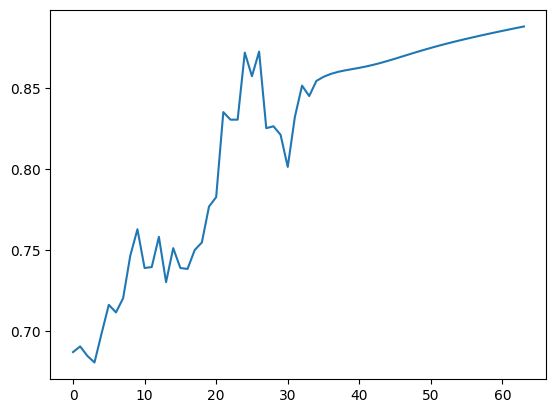

In [52]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [53]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

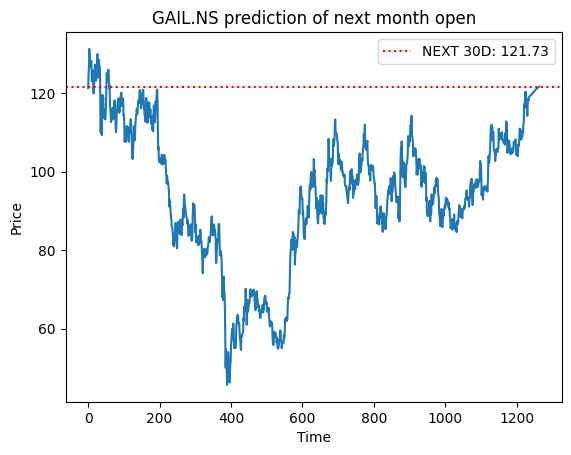

In [54]:
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

